In [5]:
'''
This script interpolates the EVI and LSWI for 2021 and save the file
'''

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from datetime import datetime
import glob
from scipy import interpolate
from scipy.interpolate import interp1d
import time

DataDir     = "/data0/dwei/Landsat/2021/TimeSeries/"
FigDir_temp = "/data0/dwei/temp/"
PlotDir     = '/data0/dwei/plotdata/'

# Sort the files in sequence based on day of year
TS_files = glob.glob(DataDir+'*EVI*')
DOY      = []
Files    = []
for file in TS_files:  
    # append the files
    Files.append(file)
    # find the corresponding DOY
    timestr  = file[-8:]
#     print(timestr)
    dt = datetime.strptime(timestr, '%Y%m%d')
    dd = dt.date()          # only date without time
    doy= dd.strftime('%j')  # Day of year as a string
    DOY.append(int(doy))
    
files_sorted = [x for _, x in sorted(zip(DOY, Files))]
# print(files_sorted)
# print(np.size(files_sorted))

In [6]:
# Read in the raw files  in temporal sequence (37 for EVI and LSWI, respectively)
EVI_ave   = []
LSWI_ave  = []
EVI_all   = np.empty((2411760, len(files_sorted)))
LSWI_all  = np.empty((2411760, len(files_sorted)))
DOY       = []  # Day of year
Timestamp = []  # Timestamp
Dates     = []  # datetime format

count     = 0
for file in files_sorted:
    data= pd.read_csv(file)
    
    # The date for the file
    Date= data["Time"][0]    
    dt  = datetime.strptime(Date, '%Y-%m-%d')
    Timestamp.append(datetime.timestamp(dt)) # Timestamp
    DOY.append(int(dt.strftime('%j')))       # Day of year
    Dates.append(dt.date())                  # datetime format
   
    # The average EVI and LSWI values    
    EVI = data["EVI"]     
    EVI_ave.append(np.nanmean(EVI))
    LSWI = data["LSWI"]     
    LSWI_ave.append(np.nanmean(LSWI))
    
    # Store all the EVI and LSWI into one file
    EVI_all[:, count] = EVI
    LSWI_all[:, count]= LSWI
    count+=1

# # Save the EVI in one file and calculate the region mean
# # Create a list of date strings
# date_lst = []
# for date in Dates:
#     date_lst.append(str(date))
    
# df_evi = pd.DataFrame(EVI_all, columns=date_lst)
# print(df_evi.head())
# df_evi.to_csv('/data0/dwei/Landsat/2021/EVI_all_raw')  

# # Save the LSWI in one file and calculate the region mean
# df_lswi = pd.DataFrame(LSWI_all, columns=date_lst)
# print(df_lswi.head())
# df_lswi.to_csv('/data0/dwei/Landsat/2021/LSWI_all_raw')  

/opt/sw/anaconda3/envs/GDAL+/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/opt/sw/anaconda3/envs/GDAL+/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


   2021-01-07  2021-01-15  2021-01-23  2021-02-08  2021-02-24  2021-03-04  \
0      0.3443         NaN      0.3436         NaN         NaN         NaN   
1      0.2826         NaN      0.2835         NaN         NaN         NaN   
2      0.2525         NaN      0.2983         NaN         NaN         NaN   
3      0.2620         NaN      0.2850         NaN         NaN         NaN   
4      0.2877         NaN      0.2934         NaN         NaN         NaN   

   2021-03-12  2021-03-20  2021-04-05  2021-04-13  ...  2021-10-06  \
0      0.3127         NaN      0.3485         NaN  ...         NaN   
1      0.2366         NaN      0.2622         NaN  ...         NaN   
2      0.2309         NaN      0.2377         NaN  ...         NaN   
3      0.2535         NaN      0.2481         NaN  ...         NaN   
4      0.2484         NaN      0.2572         NaN  ...         NaN   

   2021-10-14  2021-10-22  2021-10-30  2021-11-07  2021-11-15  2021-11-23  \
0         NaN      0.4365         NaN  

In [8]:
# Interpolate the EVI and LSWI along time
start_time = time.time()

# Pre-nterpolation 
EVI_np = df_evi.to_numpy()
LSWI_np= df_lswi.to_numpy()
# print(np.shape(EVI_np), np.shape(LSWI_np)) #(2411760, 37)
# print(DOY) # 37 dates

# Interpolated data
xnew = range(1, 366, 1)
EVI_intp = np.empty((np.size(EVI_np[:,0]), len(xnew)))
EVI_intp[:] = np.nan
LSWI_intp = np.empty((np.size(LSWI_np[:,0]), len(xnew)))
LSWI_intp[:] = np.nan
print(np.shape(EVI_intp), np.shape(LSWI_intp))

def EVI_LSWI_interp(x, y, xnew):
    '''
    x: the sparse x 
    y: the sparse y
    xnew: the wanted x
    '''    
    # Remove NaN in evi
    test  = [(w1,w2) for (w1,w2) in zip(x, y) if ~np.isnan(w2)]
    x_non = [w1 for (w1,w2) in test]
    y_non = [w2 for (w1,w2) in test]
    
    # Cubic-spline interpolation
    # if ext=3, return the boundary value
    # if ext=0, return the extrapolated value.
    # if ext=1, return 0
    if np.size(x_non)<4:
        ynew = np.zeros((365))
    # print("Too few data points for cubic-spline interpolation!")
    else:        
        tck  = interpolate.splrep(x_non, y_non)
        ynew = interpolate.splev(xnew, tck, ext=1) 
    
    # set all zeros generaged by the interpolation to nan
    ynew[ynew==0.0] = np.nan
    return ynew

for x in range(0, 2411760):
    evi = EVI_np[x, :] 
    lswi= LSWI_np[x, :] 
    
    ynew_evi = EVI_LSWI_interp(DOY, evi, xnew)
    ynew_lswi= EVI_LSWI_interp(DOY, lswi, xnew)
    
    EVI_intp[x, :] = ynew_evi
    LSWI_intp[x, :]= ynew_lswi
    
# # Save the interpolated LSWI in a single file
# start_time = time.time()

# df_evi = pd.DataFrame(data=EVI_intp)
# print(df_evi.head())
# df_evi.to_csv('/data0/dwei/Landsat/2021/EVI_all_intp_row2411760') 

# df_lswi = pd.DataFrame(data=LSWI_intp)
# print(df_lswi.head())
# df_lswi.to_csv('/data0/dwei/Landsat/2021/LSWI_all_intp_row2411760') 

print("--- %s minutes ---" % (time.time()/60 - start_time/60))
    
# clear_output(wait=True)


(2411760, 365) (2411760, 365)
--- 12.303109984844923 minutes ---


In [76]:
# Save the interpolated EVI and LSWI by month
months= [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Mon   = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
def save_EVI_LSWI_by_month(Data, OutDir):
    Data_tmp = Data
    i = 0
    for mon in months:
        print("------- Processing %s --------" %(Mon[i]))
        df = pd.DataFrame(data=Data_tmp[:,0:months[i]])
        df.to_csv(OutDir + Mon[i])                 
        Data_tmp = Data[:,months[i]:]
        i+=1       

start_time = time.time()

LSWIDir = '/data0/dwei/Landsat/2021/LSWI_intp_'
EVIDir  = '/data0/dwei/Landsat/2021/EVI_intp_'
save_EVI_LSWI_by_month(LSWI_intp, LSWIDir)
save_EVI_LSWI_by_month(EVI_intp, EVIDir)
    
print("--- %s minutes ---" % (time.time()/60 - start_time/60))


   0    1    2    3    4    5       6         7         8         9    ...  \
0  NaN  NaN  NaN  NaN  NaN  NaN  0.3443  0.345071  0.345713  0.346231  ...   
1  NaN  NaN  NaN  NaN  NaN  NaN  0.2826  0.283486  0.284243  0.284877  ...   
2  NaN  NaN  NaN  NaN  NaN  NaN  0.2525  0.257543  0.262261  0.266661  ...   
3  NaN  NaN  NaN  NaN  NaN  NaN  0.2620  0.265056  0.267863  0.270427  ...   
4  NaN  NaN  NaN  NaN  NaN  NaN  0.2877  0.289139  0.290411  0.291520  ...   

   355  356  357  358  359  360  361  362  363  364  
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 365 columns]


/opt/sw/anaconda3/envs/GDAL+/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


(365,) (365,)


/opt/sw/anaconda3/envs/GDAL+/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


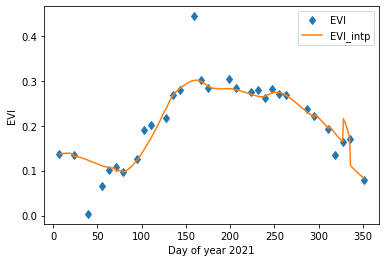

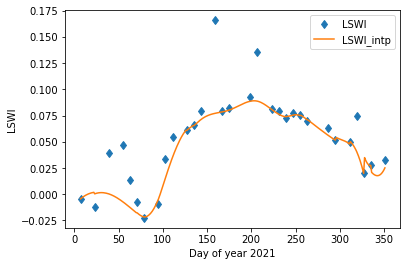

In [13]:
# Calculate the region mean based on the interpolated EVI
EVI_intp_ave  = np.nanmean(EVI_intp, axis=0)
LSWI_intp_ave = np.nanmean(LSWI_intp, axis=0)
print(np.shape(EVI_intp_ave), np.shape(LSWI_intp_ave))

plt.figure(1)
plt.plot(DOY, EVI_ave, 'd')
plt.plot(range(1, 366), EVI_intp_ave)
plt.ylabel("EVI")
plt.xlabel("Day of year 2021")
plt.legend(['EVI', 'EVI_intp'])
plt.show()

plt.figure(2)
plt.plot(DOY, LSWI_ave, 'd')
plt.plot(range(1, 366), LSWI_intp_ave)
plt.ylabel("LSWI")
plt.xlabel("Day of year 2021")
plt.legend(['LSWI', 'LSWI_intp'])
plt.show()